# ToolNode 를 사용한 도구 사용기능 만들기
- 계산기, 날씨, 환율 도구

# 사전 설치 필요

In [1]:
# 설치 필요
# pip install geopy 

from geopy.geocoders import Nominatim

# Nominatim geocoding class from the geopy library. 
# 주소를 좌표(위도, 경도)  혹은 좌표를 주소로 변환해두는 geocoding 라이브러리
# This class allows developers to convert addresses into geographic coordinates (latitude and longitude) and vice versa. 

# import

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import httpx   # http 클라이언트 라이브러리 (비동기/동기 요청 모두 가능.)
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain.chat_models import init_chat_model
import math
from geopy.geocoders import Nominatim
from IPython.display import Image, display

# 도구들 Tools

## 계산기 도구

In [4]:
"10 + 20"

'10 + 20'

In [5]:
eval("10 + 20")

30

In [6]:
"sqrt(2)"

'sqrt(2)'

In [7]:
eval("math.sqrt(2)")

1.4142135623730951

In [8]:
def calculator(expression: str) -> str:
    """수학 계산을 수행합니다."""
    print(f"계산 요청: {expression}")

    try:
        # 간단한 치횐
        expression.replace("sqrt", "math.sqrt")
        expression.replace("sin", "math.sin")
        expression.replace("cos", "math.cos")
    
        # 계산 실행
        # ※ eval() 은 파이썬 코드를 모드 실행할수 있기에, 위험한 실행동작을 예방하기 위해
        #    math 패키지만 사용하도록 제한.
        result = eval(expression, {"__builtins__": {}, "math": math})
        return f"계산 결과: {result}"

    except Exception as e:
        return f"계산 오류: {str(e)}"
        

## 날씨 정보 도구

In [9]:
def get_coordinates(city_name: str) -> tuple[float, float]:
    """도시 이름을 받아 위도와 경도를 반환합니다"""
    geolocator = Nominatim(user_agent="weather_app")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError(f"Could not find coordinate for {city_name}")

# 테스트
# get_coordinates("비키니시티")

In [10]:
def get_weather(city_name: str) -> dict:
    """도시 이름을 받아 해당 도시의 현재 날씨 정보를 반환합니다."""

    if city_name:
        latitude, longitude = get_coordinates(city_name)
    else:
        raise ValueError("City name must be provided to get weather information.")

    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true" 
    response = httpx.get(url)    
    response.raise_for_status()  # HTTP 에러시 예외 발생
    return response.json()

# 테스트
# get_weather("서울")

## 환율 계산 도구

In [11]:
def currency_converter(amount: float, from_currency: str, to_currency: str) -> str:
    "통화 간 환율을 계산합니다"
    print(f"{amount} {from_currency}를 {to_currency}로 변환합니다")
    rates = {("USD", "KRW"): 1450.50, ("KRW", "USD"): 0.00076}
    rate_key = (from_currency.upper(), to_currency.upper())

    if rate_key in rates:
        rate = rates[rate_key]
        converted = amount * rate
        return f"{amount} {from_currency} = {converted:.2f} {to_currency}"

    return f"{amount} {from_currency} = {amount} {to_currency} (동일 통화)"
        
        
# 테스트
currency_converter(1000000, "krw", "usd")
    

1000000 krw를 usd로 변환합니다


'1000000 krw = 760.00 usd'

# 랭그래프 워크플로

## 분기 노드

In [12]:
# 조건부 라우팅에 사용할 분기 노드
def shoud_continue(state: MessagesState):
    print("\n---- 분기 결정 ----")
    last_message = state['messages'][-1]

    if last_message.tool_calls:
        print(f"결정: 도구 호출 필요 ({len(last_message.tool_calls)}개)")
        return "tools"
    else:
        print("결정: 최종응답으로 종료")
        return END



## call_model 노드를 생성하는 함수

In [ ]:
# 랭그래프의 노드로 사용하려면 State 매개변수 하나만 갖고 있어야 한다.
# 추가적인 매개변수가 필요하다면, 다른 함수로 한번 감싸서 노드함수를 리턴하도록 한다

In [13]:
def create_call_model_function(model_with_tools):

    def call_model(state: MessagesState):
        """LLM 을 호출하여 응답을 생성하느 노드 함수"""
        last_message = state['messages'][-1]

        # 도구 실행 결과를 받았는지, 아니면 사용자 질문을 받았는지에 따라 분기
        if isinstance(last_message, ToolMessage):
            print("\n--- 모델 호출 (도구 결과 기반)---")
            print(f"입력(도구결과): {last_message.content[:300]}...")
        else:
            print("\n--- 모델 호출 (사용자 질문 기반)---")
            print(f"입력(사용자메세지): {last_message.content}")

        # 모델을 호출하여 다음 행동을 결정하게 함
        response = model_with_tools.invoke(state['messages'])

        # 모델의 결정에 따라 로그 출력
        if response.tool_calls:
            print(f"모델의 판단: 도구 호출 -> {response.tool_calls}")
        else:
            print(f"모델의 파단: 최종 답변 생성 -> {response.content}")

        return {"messages": [response]}

    return call_model

## 워크플로 를 생성하는 함수

In [ ]:
"""
② 워크플로를 생성하는 함수: 
워크플로는 'START → call_model → [(도구를 사용해야 하면) toolscall_model]-・END'가 됩니다. 
분기 부분은 이미 학습한 add_conditional_edges()를 사용했습니다. 
워크플로를 말로 풀어보면 다음과 같습니다.

• 유저가 메시지 입력
• 모델에서 도구 호출이 필요한지 판단
• 도구 호출이 필요하면 tool_node에서 도구 실행
• 도구의 실행 결과를 받아서 모델에서 최종응답 생성
• 최종 응답 출력
"""
None

In [17]:
def create_graph(model_with_tools, tool_node):
    """LLM 워크플로 그래프 생성"""

    workflow = StateGraph(MessagesState)

    call_model = create_call_model_function(model_with_tools)
    
    workflow.add_node("call_model", call_model)
    workflow.add_node("tools", tool_node)

    workflow.add_edge(START, "call_model")
    workflow.add_conditional_edges(
        "call_model",
        shoud_continue,
        ["tools", END]
    ) # 조건부 라우팅
    workflow.add_edge("tools", "call_model")


    return workflow.compile()

## 워크플로 생성 및 실행

In [18]:
# "2 + 3 * 4 를 계산해줘"
# "서울 날씨 어때?"

In [21]:
def llm_tool_call(query: str):
    """하나의 질문에 대해 전체 LLM 워크플로를 실행하고 로그를 출력합니다."""
    tools = [calculator, get_weather, currency_converter]
    tool_node = ToolNode(tools)

    model = init_chat_model("gpt-4o", model_provider="openai")
    model_with_tools = model.bind_tools(tools)

    print(f"질문: {query}")
    print("-" * 50)

    app = create_graph(model_with_tools, tool_node)

    app.invoke({"messages": [HumanMessage(content=query)]})

    png = app.get_graph().draw_mermaid_png()
    with open("./06_tool_calling.png", "wb") as f:
        f.write(png) # 💛

    print('-' * 50)
    print("처리 완료")
    print("=" * 50 + "\n")

In [25]:
test_queries = [
    # "2 + 3 * 4를 계산해줘",
    # "서울 날씨 어때?",
    # "100달러를 원화로 바꿔줘",
    # "안녕하세요",
    "100 * 200 을 계산해주고 이 결과를 달러에서 원화로 바꿔줘",  # calculator 와 currency_converter 도구 호출 
    
]

print("\nLLM 기반 도구 호출 시작:")
for query in test_queries:
    try:
        llm_tool_call(query)
    except Exception as e:
        print(f"'{query}' 처리 중 오류 발생: {e}")
        print("=" * 50 + "\n")








LLM 기반 도구 호출 시작:
질문: 100 * 200 을 계산해주고 이 결과를 달러에서 원화로 바꿔줘
--------------------------------------------------

--- 모델 호출 (사용자 질문 기반)---
입력(사용자메세지): 100 * 200 을 계산해주고 이 결과를 달러에서 원화로 바꿔줘
모델의 판단: 도구 호출 -> [{'name': 'calculator', 'args': {'expression': '100 * 200'}, 'id': 'call_NJp9DlDxhS2budpBPElJt3VA', 'type': 'tool_call'}, {'name': 'currency_converter', 'args': {'amount': 1, 'from_currency': 'USD', 'to_currency': 'KRW'}, 'id': 'call_dLkDlpkYNmRBDZcanvNoWf65', 'type': 'tool_call'}]

---- 분기 결정 ----
결정: 도구 호출 필요 (2개)
계산 요청: 100 * 200
1.0 USD를 KRW로 변환합니다

--- 모델 호출 (도구 결과 기반)---
입력(도구결과): 1.0 USD = 1450.50 KRW...
모델의 파단: 최종 답변 생성 -> 100 * 200의 계산 결과는 20,000입니다. 현재 환율에 따르면 1달러는 1,450.50 원입니다. 따라서 20,000 달러는 다음과 같이 계산할 수 있습니다.

20,000 USD * 1,450.50 KRW/USD = 29,010,000 KRW

따라서, 20,000 달러는 약 29,010,000 원입니다.

---- 분기 결정 ----
결정: 최종응답으로 종료
--------------------------------------------------
처리 완료



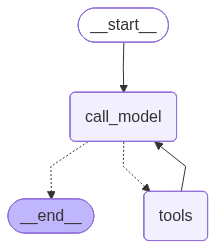

In [26]:
Image("06_tool_calling.png")